In [1]:
import os
import re
import random
import numpy as np
import tensorflow as tf 
import tensorflow.keras as keras
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LeakyReLU, Input, Reshape, Conv1DTranspose, Lambda, Embedding, LSTM, RepeatVector

In [2]:
#this line only in colab
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Loading and preprocessing the dataset

In [3]:
folder = os.getcwd()+'/gdrive/MyDrive/'

In [4]:
print(os.listdir(folder))

['Google Fotos', 'IMG_20170516_094213.jpg', 'FB_IMG_1547999529671.jpg', 'berlin', 'IMG_0904.JPG', 'IMG_1824.JPG', 'FOTO_01.jpg', 'SebasDocs', 'WhatsApp Chat mit +49 1573 8880850.txt', 'FOTO_02.jpg', 'FOTO_03.jpg', 'FOTO_04.jpg', 'FB_IMG_1561892726387.jpg', '20200605_110251.jpg', 'Video von .', 'Colab Notebooks', '.ipynb_checkpoints', 'haarcascade_frontalface_default.xml', 'Bewerbungsfoto.jpg', 'cats_and_dogs.zip', 'cats_and_dogs', '__MACOSX', 'Noisy_Documents', 'denoiser.h5', 'att_faces', 'sample_faces', 'doge.png', 'landscape.jpeg', 'landscapeDream.png', 'landscape2.jpeg', 'landscapeDream2.png', 'zulpi.jpg', 'landscape3.jpeg', 'landscapeDream3.png', 'landscapeDream3_2.png', 'landscape4.jpeg', 'landscapeDream4.png', '1610.00291.pdf', 'celeb_a.zip', '2007.08128.pdf', 'textos', 'corpus', 'text_gen_sp.h5', 'text_gen_sp2.h5', 'top-10000-passwords.txt', 'rockyou.txt', 'yahoo.txt']


In [5]:
file = 'yahoo.txt'

In [6]:
text = open(folder+file, errors='ignore', encoding='utf-8').read().lower()
text = text.split() #this makes sure to pick up the words
text = ' '.join(text) #this takes all the letters without the separators

In [7]:
print(text[-100:])

ra24 blu-fire leeonna7211 partys56 wegotmoney$ elro1014 a$$c0n wow777iee mustacchi 123321qq asdf1234


## Encoding the characters:

In [8]:
 #number of distinct characters:
chars = sorted(list(set(text))) #takes the whole characters as a set where no duplicates are allowed
vocab_size = len(chars)
print('Number of unique characters: ', vocab_size)

Number of unique characters:  73


In [9]:
#dictionary to match unique charaters with their index:
char_indices = {char:chars.index(char) for char in chars}

In [10]:
char_array = np.array(chars)
print(char_array)

[' ' '!' '#' '$' '%' '&' '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2' '3'
 '4' '5' '6' '7' '8' '9' ':' ';' '=' '?' '@' '[' '\\' ']' '^' '_' '`' 'a'
 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '|' '}' '~' '¦' '±' '´' 'ç' 'ü' 'č' 'ł'
 'ń']


In [11]:
chars_encoded = np.array([char_indices[ch] for ch in char_array], dtype='int32')
print(chars_encoded)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]


In [12]:
#dictionary that matches indices with their characters:
indices_char = {idx: chars[idx] for idx in chars_encoded}

In [242]:
#encoding of the whole text:
text_encoded = np.array([char_indices[ch] for ch in text], dtype='int32')

In [13]:
#search iteratively for different characters to be split e.g. @fl!pm0de = @ fl ! pm 0 de
seqs = ' '.join(re.split('(\d+)',text))
seqs = ' '.join(re.split('(\@)',seqs))
seqs = ' '.join(re.split('(\!)',seqs))
word_list = seqs.split()
print(word_list[:20])

['@', 'fl', '!', 'pm', '0', 'de', '@', 'pass', 'steveol', 'chotzi', 'lb', '2512', 'scotch', 'passwerd', 'flipmode', 'flipmode', 'alden', '2', 'salmon', 'tagoogle']


In [76]:
# Most popular sequences:
word_counter = {}
for word in word_list:
  if word in word_counter:
    word_counter[word] += 1
  else:
    word_counter[word] = 1
popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_30k = popular_words[:30000]
#random.shuffle(top_30k) (optional)
print(top_30k[:30])

['1', '2', '123', '3', '4', '7', '0', '12', '5', '8', '!', '9', '6', '11', 'a', '@', '01', '13', '22', '23', '123456', '1234', 'm', '21', '10', 'b', '99', 'r', '69', 'd']


In [77]:
#encoding the characters of all the popular password sequences:
sequences = []
for word in top_30k:#text.split():
    sequences.append([char_indices[ch] for ch in word])

In [78]:
# padding sequences:
padded = sequence.pad_sequences(sequences)

In [79]:
max_len = len(padded[0])
print('lenght of sequences:', max_len)

lenght of sequences: 20


In [80]:
print('Number of sequences:',len(sequences))

Number of sequences: 30000


In [81]:
#finally the encoded passwords are given as an array of integers:
pass_encoded = np.array(padded, dtype='int32')
print(pass_encoded[-10:])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 54 43 54]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 53 44 49 36 53 49 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 42 35 54 37 35 54]
 [ 0  0  0  0  0  0  0  0  0  0 53 45 35 54 39 49 52 38 43 39]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 36 43 41 36 55 36 36 35]
 [ 0  0  0  0  0  0  0  0 54 42 35 48 45 53 41 43 56 43 48 41]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 53 54 35 48 41 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15 18 22 16]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 38 43 53 50 46 35 59]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15 14 14 17 17]]


## Definition of the training variables:

In [139]:
#normalized sequences:
#X = pass_encoded.astype('float32')
X = some_set.astype('float32')

In [140]:
print(X[0])

[  0.  13.  21. 221.  26.  22.  31.  12.  88.  28.  18.  30.  32.  75.
   3. 135.]


In [141]:
#training variables
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True, random_state=42)

In [142]:
print(X_train.shape, X_test.shape)

(4000, 16) (1000, 16)


In [143]:
y_train, y_test = X_train.reshape((X_train.shape[0], X_train.shape[1],1)), X_test.reshape((X_test.shape[0], X_test.shape[1],1))

In [144]:
print(y_train.shape, y_test.shape)

(4000, 16, 1) (1000, 16, 1)


In [145]:
print(X_train[0])

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 24847. 24848. 24849. 24850. 24851. 24852.]


In [146]:
#This is helpful for word-level encodings:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler() #Friendship ended with Standard Scaler now MinMaxScaler is my best friend
ys_train = sc.fit_transform(X_train).reshape((X_train.shape[0], X_train.shape[1],1))
ys_test = sc.transform(X_test).reshape((X_test.shape[0], X_test.shape[1],1))

##Model Training


In [147]:
#construction of the latent space from a Gaussian Distribution:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(tf.shape(z_log_var))
    return z_mean + epsilon*K.exp(z_log_var/2)

In [170]:
latent_size = 8
# latent_size=16 is the optimum
encoder_inputs = Input(shape=(X_train.shape[1],1), name='Input')
x = keras.layers.GRU(16, return_sequences=True)(encoder_inputs)
x = Conv1D(16, 3, activation='relu', padding='causal', dilation_rate=1)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(32, 3, activation='relu', padding='causal', dilation_rate=2, use_bias=False)(x) 
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(64, 3, activation='relu', padding='causal', dilation_rate=4, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(128, 3, activation='relu', padding='causal', dilation_rate=8, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(256, 3, activation='relu', padding='causal', dilation_rate=16, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Flatten()(x)
x = Dense(2*latent_size, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
z_mean = Dense(latent_size, name='Mean', use_bias=False)(x)
z_log_var = Dense(latent_size, name='Variance', use_bias=False)(x)
z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_inputs, outputs=z, name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
gru_8 (GRU)                     (None, 16, 16)       912         Input[0][0]                      
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 16, 16)       784         gru_8[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu_48 (LeakyReLU)      (None, 16, 16)       0           conv1d_20[0][0]                  
____________________________________________________________________________________________

In [171]:
decoder_inputs = Input(shape=(latent_size,), name='Input')
x = Dense(X_train.shape[1]*2*128)(decoder_inputs)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Reshape((X_train.shape[1],2*128))(x)
x = Conv1DTranspose(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=64, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=16, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GRU(16, return_sequences=True, use_bias=False)(x)
x = keras.layers.TimeDistributed(Dense(1), name='Output')(x) 
decoder = keras.Model(inputs=decoder_inputs, outputs=x, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 8)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              36864     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 4096)              16384     
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 256)           0         
_________________________________________________________________
conv1d_transpose_20 (Conv1DT (None, 16, 256)           196608    
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 16, 256)           0   

In [172]:
codings=encoder(encoder_inputs)
reconstructions=decoder(codings)
#Bottleneck of size 16 with input lenght 20
vae=keras.Model(inputs=encoder_inputs, outputs=reconstructions, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 16, 1)]           0         
_________________________________________________________________
Encoder (Functional)         (None, 8)                 200096    
_________________________________________________________________
Decoder (Functional)         (None, 16, 1)             383953    
Total params: 584,049
Trainable params: 573,841
Non-trainable params: 10,208
_________________________________________________________________


In [173]:
#KL-divergence:
vae_loss = -0.5*K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)

In [174]:
#Mean-Squared-Error:
MSE=tf.squeeze(K.sum(K.square(vae.input-vae.output),axis=1),1)

In [175]:
#ELBO = Reconstruction loss + KL-divergence:
ELBO=K.mean(vae_loss+X_train.shape[1]*MSE)

In [176]:
vae.add_metric(ELBO, name='ELBO')

In [177]:
#Best reconstruction loss (MSE) so far is achieved when the KL divergence is divided by 2000 and a GRU layer is included.
#The optimization is Adam with default learning rate 
vae.add_loss(K.mean(vae_loss)/160) #--> KL_loss/original_dims *10
#vae.add_metric(vae_loss, name='KL')

In [178]:
opt = keras.optimizers.Adam()
loss = keras.losses.MeanSquaredError()

In [179]:
vae.compile(loss=loss, optimizer=opt)

In [180]:
#log_dir = "logs/fit/"
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_ELBO', factor=0.1, patience=5)
ES = tf.keras.callbacks.EarlyStopping(monitor='ELBO', patience=5)
#TB = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
callbacks_list = [LR, ES]

In [101]:
#Train for approximately 150 epochs for best results
#the bigger the dataset the better the results
history = vae.fit(y_train, y_train, validation_data=(y_test, y_test), epochs=150, shuffle=True, batch_size=256, callbacks=callbacks_list)

Epoch 1/150
94/94 [==============================] - 16s 92ms/step - loss: 447.1179 - ELBO: 166370.6562 - val_loss: 398.6985 - val_ELBO: 159608.0156
Epoch 2/150
94/94 [==============================] - 7s 72ms/step - loss: 372.0003 - ELBO: 145207.6094 - val_loss: 359.5992 - val_ELBO: 143957.3594
Epoch 3/150
94/94 [==============================] - 7s 73ms/step - loss: 339.1482 - ELBO: 132216.9219 - val_loss: 319.2882 - val_ELBO: 127816.5391
Epoch 4/150
94/94 [==============================] - 7s 73ms/step - loss: 311.1933 - ELBO: 120925.6719 - val_loss: 291.0885 - val_ELBO: 116519.9453
Epoch 5/150
94/94 [==============================] - 7s 74ms/step - loss: 282.6779 - ELBO: 110720.9375 - val_loss: 266.3232 - val_ELBO: 106602.6016
Epoch 6/150
94/94 [==============================] - 7s 73ms/step - loss: 260.4909 - ELBO: 101374.6719 - val_loss: 243.6962 - val_ELBO: 97548.4141
Epoch 7/150
94/94 [==============================] - 7s 73ms/step - loss: 236.9995 - ELBO: 92788.6094 - val_loss

In [ ]:
%tensorboard --logdir logs/fit

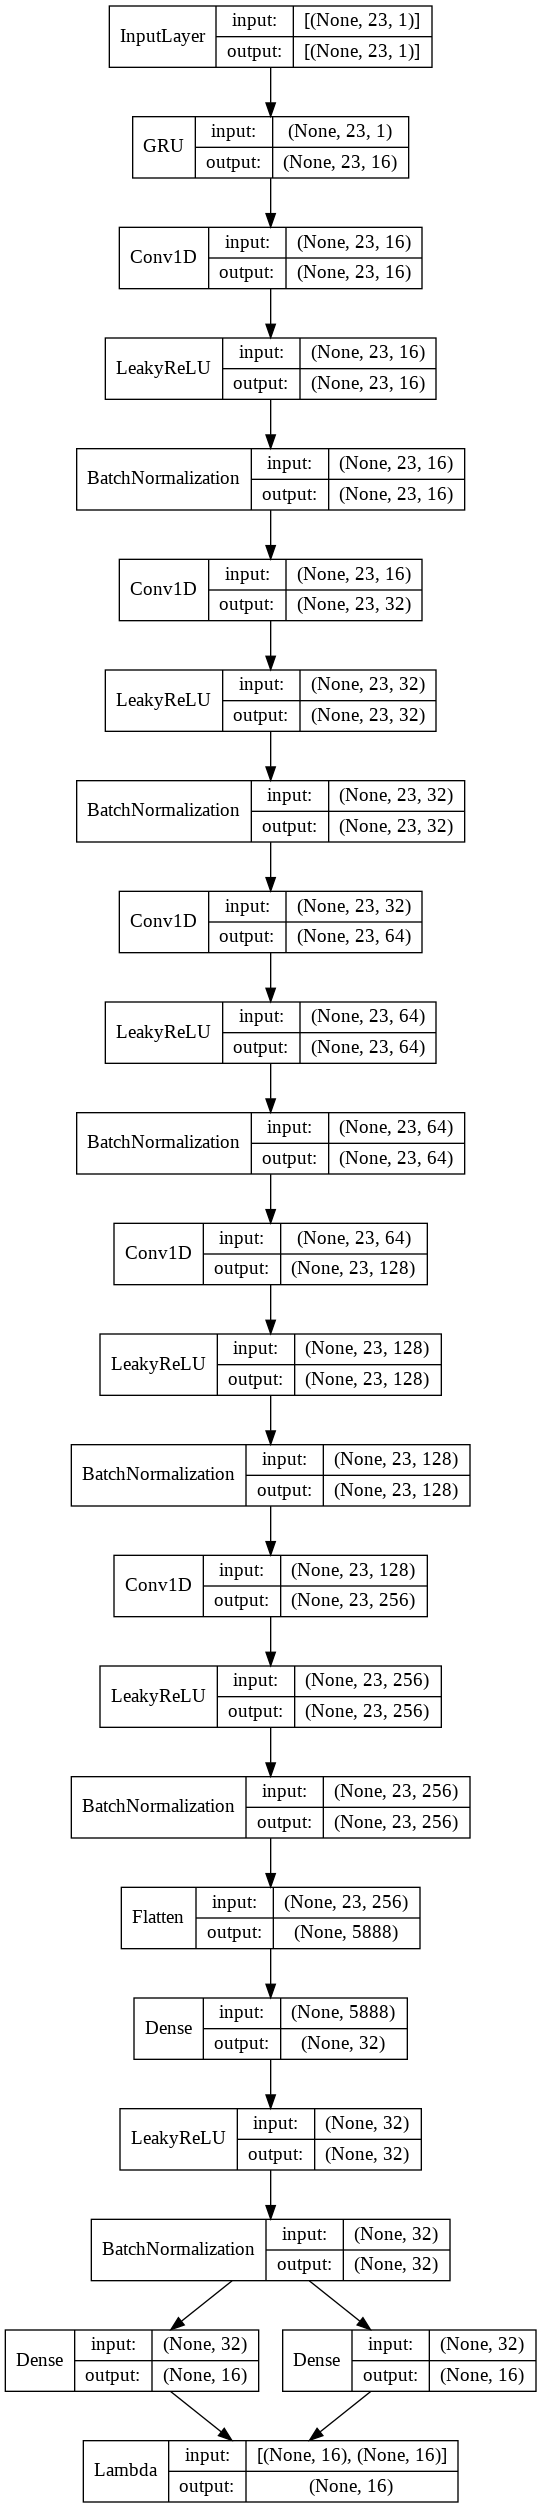

In [50]:
from keras.utils import plot_model
plot_model(model=encoder, show_shapes=True, show_layer_names=False,to_file='Encoder.png')

In [ ]:
score = vae.evaluate(y_test,y_test)

625/625 [==============================] - 6s 7ms/step - loss: 0.2100 - ELBO: 65.7840


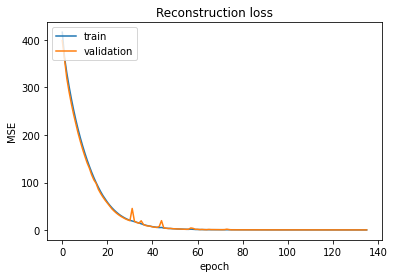

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Reconstruction loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

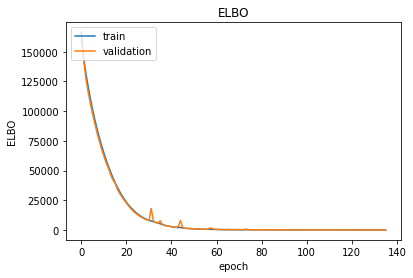

In [103]:
plt.plot(history.history['ELBO'])
plt.plot(history.history['val_ELBO'])
plt.title('ELBO')
plt.ylabel('ELBO')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [104]:
example = tf.random.normal(shape=(10000,latent_size))

In [105]:
#preds = sc.inverse_transform(tf.squeeze(vae.predict(ys_test)).numpy()).astype('int32')
preds = tf.squeeze(vae.predict(y_test)).numpy().astype('int32')
print(preds[:10])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 38 34 46 54 48 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 47 35 48 38 48 46 42 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 54 48 35]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 37 56 53 46]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 35 39 45 48 55 39 38]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 55 39 46]
 [ 0  0  0  0  0  0  0  0  0  0  0 40 54 42 54 35 52 47 35 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 48 51 43 41 42 47 35 46]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 52 38 46 39 47 38]
 [ 0  0  0  0  0  0  0  0  0 56 52 42 54 42 48 40 39 49 49 46]]


In [106]:
print(X_test[:10].astype('int32'))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 38 35 46 54 49 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 47 35 48 38 49 46 43 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 54 48 36]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 38 59 53 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 36 39 46 49 56 39 38]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 56 39 46]
 [ 0  0  0  0  0  0  0  0  0  0  0 41 55 43 54 35 52 47 35 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 49 52 43 41 43 48 35 46]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 53 39 46 39 48 39]
 [ 0  0  0  0  0  0  0  0  0 57 52 43 54 43 48 41 40 49 49 46]]


In [107]:
print(np.abs(tf.squeeze(decoder(example)).numpy()).astype('int32')[:10])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 35 39 49 42]
 [ 0  0  0  0  0  0  0  0  1  1  1  0  2  2  0 29 42 39 37 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 37 31 49 49 51]
 [ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  0 33 32 46 38 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 34 51 49 41 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 39 48 44 54 38 35 48]
 [ 0  0  0  0  0  0  0  0  0  0  2  4  5  1  8 15 31 39 35 41]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 39 45 56 50 45 41 50 53]
 [ 0  0  0  0  0  0  0  1  1  1  0 23  9  6 32 39 35 33 32 29]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  5 20 36 30 30 37 52]]


In [109]:
def samples2text(samples):
  result = tf.squeeze(decoder(samples))
  result_encoded=np.abs(result.numpy().astype('int32'))

  passwords = []
  for word in result_encoded:
    passwords.append([indices_char[idx] for idx in word])
    passworten = [''.join(code).strip() for code in passwords]

  return passworten

In [110]:
def seqs2text(arr):

  passwords = []
  for word in arr:
    passwords.append([indices_char[idx] for idx in word])
    passworten = [''.join(code).strip() for code in passwords]

  return passworten

In [111]:
print(' '.join(samples2text(example[-200:])))

!bi_oge !oi`grhl ]angen *a:29:gd eghlom jpipooh !mgiubo !!13.kjls ! $e?c\kgk\h bcgdegk` coli 69_lgfv^ -lcckqlar jhga?gf`m eddb_gp #  itdkdeh !cgekl@ cklgogjan aghf 7[gihgadcal !*$! !vngi _eeqmaro !^plmg_pk :unni #!$0496d afe^e bkqjjpd !@2!(gad6 !!)lhdsne !( ?lgj[h`f^p ;beipe =jkjlisnmqq #!$eqcunurr !$$!  7/018 !!.k_j ! $%6,5hhfa]e %!7neeu )oisorofs (!ckce !![clms^gl #!`vgruok \kneikglad (`jkm`ngs #  i^jdc !! !!%\_a?n cbekj bdlrkn jddklk d_csjrvr !%   heh -346:[?@@] pekobd afdfhg #/f?c]\n fpb $!!!^pmr (_bjuejsv ;bake@ bv^gooo @_c`agpk atdecjk_j ahaghefb ;nqlidcl !! ! # %!5gtju jgkbemv 2faogve _jli !# ,a8;!\ke df[sfdpjf )fpsdeldt 98pusajjhd !!$mgbcijgd``l #!ffod 115341 @ajpadabln =a\h`g_ knhpem # $dcq hgidje ! )4akhfk ! # *cudln^f 8^sk@bb]d !## #%&(cap !#4.#gri `mtmh jfmoncg gqvponv =6f^`j^ !##!!  +jmjkh _gpfcdkoag ^jkipplq 9gb`kecj $()&#(;7^ $1557gk5 2?;@=8:=\9 !! ##=. jkofm baonqp llmuqm !  ckkebpaherc ^hic_h #$ hbahfho $(?`idpj #%6h=:fd? ]fgamdlo 1?kcpnno !a[49 hbr (eapmpiaj ]nuanpfkm

In [ ]:
vae.save('1d_vae.h5',overwrite=True)

In [112]:
print(np.abs(preds[:10]))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 38 34 46 54 48 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 47 35 48 38 48 46 42 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 54 48 35]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 37 56 53 46]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 35 39 45 48 55 39 38]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 55 39 46]
 [ 0  0  0  0  0  0  0  0  0  0  0 40 54 42 54 35 52 47 35 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 48 51 43 41 42 47 35 46]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 52 38 46 39 47 38]
 [ 0  0  0  0  0  0  0  0  0 56 52 42 54 42 48 40 39 49 49 46]]


In [113]:
print(X_test[:10].astype('int32'))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 38 35 46 54 49 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 47 35 48 38 49 46 43 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 54 48 36]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 38 59 53 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 36 39 46 49 56 39 38]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 56 39 46]
 [ 0  0  0  0  0  0  0  0  0  0  0 41 55 43 54 35 52 47 35 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 49 52 43 41 43 48 35 46]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 53 39 46 39 48 39]
 [ 0  0  0  0  0  0  0  0  0 57 52 43 54 43 48 41 40 49 49 46]]


In [114]:
seqs2text(np.abs(preds[-30:]))

['oreoaqd',
 'ahfsgot',
 'snftahl',
 'ag`qsh',
 'ramcbasskd',
 'qhcdamv',
 'eurpam',
 '7/14',
 'ohvnohvn',
 'jav',
 'vhlkel',
 'apabgd',
 'jasramdqa',
 'jnjak',
 'gdvdkiah',
 'ednhkr',
 'q`rtalam',
 'gnmkeq',
 '378',
 'eqa',
 'anananan',
 'rgnvshld',
 'qveqsvuioo',
 'gdl`ms',
 '3381',
 'tnjnovm',
 '50/6',
 '1681',
 'j`laldom',
 '24051877']

In [115]:
seqs2text(X_test[-30:])

['prepare',
 'bigshot',
 'softail',
 'bharti',
 'sandcastle',
 'ridebmx',
 'furqan',
 '7025',
 'piyopiyo',
 'jax',
 'willem',
 'apache',
 'kassandra',
 'kokal',
 'hezekiah',
 'feniks',
 'rastaman',
 'honker',
 '378',
 'frb',
 'bobobobo',
 'showtime',
 'qwertzuiop',
 'hemant',
 '4492',
 'unknown',
 '5007',
 '1792',
 'kamaleon',
 '25061977']

In [111]:
#sampling a 2D latent space:
norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, 100)).numpy()
grid_y = norm.quantile(np.linspace(0.05, 0.95, 100)).numpy()

z_lat = np.array([ [xi,yi] for xi,yi in zip(grid_x,grid_y)])

In [ ]:
samples2text(z_lat)[-50:]

In [ ]:
print(tf.squeeze((decoder(z_lat))).numpy().astype('int32')[:50])

In [ ]:
latent_space = seqs2text((tf.squeeze(decoder(z_lat))).numpy())

#Generating sequences at word level:
Instead of a character based approach, here we take all of the popular sequences as plain text and divide it into equal length chunks. Thus the vocabulary here is composed of the 30k different popular sequences (words).

In [116]:
#Plain text:
# Here we make sure to shuffle the entire set of popular sequences 
top_shuffle = top_30k.copy()
#random.shuffle(top_shuffle)
plain_list = ' '.join(top_shuffle)

In [117]:
print(plain_list[:200])

1 2 123 3 4 7 0 12 5 8 ! 9 6 11 a @ 01 13 22 23 123456 1234 m 21 10 b 99 r 69 d n s 08 09 77 00 t 33 88 07 24 w password c p 19 14 j 17 k 55 e l 18 25 g h 15 06 16 2008 u 05 2009 20 27 x ac 03 q 44 12


In [118]:
print('lenght of the list:',len(plain_list))

lenght of the list: 198364


In [120]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
 
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
 
    return out

In [128]:
expt = chunkIt(plain_list, 5000)
print(len(expt))

5000


In [129]:
t = Tokenizer()
t.fit_on_texts(expt)

In [130]:
some_words = t.texts_to_sequences(expt)

In [131]:
#padding sequences
some_set = np.array(some_words, dtype=object)
some_set = keras.preprocessing.sequence.pad_sequences(some_set)

In [132]:
vocab_size = len(t.word_index)
print('Size of vocabulary:',vocab_size)

Size of vocabulary: 28899


In [133]:
print('lenght of sequence:',len(some_set[100]))

lenght of sequence: 16


In [138]:
expt[:5]

['1 2 123 3 4 7 0 12 5 8 ! 9 6 11 a @ 01 ',
 '13 22 23 123456 1234 m 21 10 b 99 r 69 d',
 ' n s 08 09 77 00 t 33 88 07 24 w passwor',
 'd c p 19 14 j 17 k 55 e l 18 25 g h 15 ',
 '06 16 2008 u 05 2009 20 27 x ac 03 q 44 ']

In [137]:
print(some_set[:5])

[[   0   13   21  221   26   22   31   12   88   28   18   30   32   75
     3  135]
 [   0    0    0  222   54   76 1625 1626    6  170   77   14  171    7
   223    8]
 [   0    0    0    4    1  172  224  136  310    5  225  173  174  226
    25 1627]
 [   8    9   11  107   89   17  546   20   61    2   15  137  138   10
    19  227]
 [   0    0    0  311  228 1628   53  108 1629   90  175   78  139  312
    62  140]]


In [181]:
history2 = vae.fit(ys_train, ys_train, validation_data=(ys_test, ys_test), epochs=150, shuffle=True, batch_size=256, callbacks=callbacks_list)

Epoch 1/150
16/16 [==============================] - 9s 141ms/step - loss: 0.1658 - ELBO: 24.2424 - val_loss: 0.1116 - val_ELBO: 27.4939
Epoch 2/150
16/16 [==============================] - 1s 68ms/step - loss: 0.0588 - ELBO: 13.9366 - val_loss: 0.1227 - val_ELBO: 28.5911
Epoch 3/150
16/16 [==============================] - 1s 69ms/step - loss: 0.0765 - ELBO: 11.8208 - val_loss: 0.1164 - val_ELBO: 27.0576
Epoch 4/150
16/16 [==============================] - 1s 67ms/step - loss: 0.0430 - ELBO: 8.8779 - val_loss: 0.1151 - val_ELBO: 26.3088
Epoch 5/150
16/16 [==============================] - 1s 66ms/step - loss: 0.0360 - ELBO: 7.8395 - val_loss: 0.1190 - val_ELBO: 26.5093
Epoch 6/150
16/16 [==============================] - 1s 66ms/step - loss: 0.0342 - ELBO: 7.4713 - val_loss: 0.1269 - val_ELBO: 27.5719
Epoch 7/150
16/16 [==============================] - 1s 66ms/step - loss: 0.0326 - ELBO: 7.1573 - val_loss: 0.1356 - val_ELBO: 28.9332
Epoch 8/150
16/16 [==============================] 

In [182]:
example = tf.random.normal(shape=(10000,latent_size))
results = np.abs(sc.inverse_transform(tf.squeeze(decoder(example)).numpy()).astype('int32'))

In [183]:
print(results[1])

[    0     0     1   141    60   193  2063  3399  4966  4845  8590 11981
  9846 10154  9223  6281]


In [184]:
rs = t.sequences_to_texts(results)

In [185]:
latent_list=''.join(rs)

In [186]:
latent_text=latent_list.replace(' ','')

In [187]:
latent_passwords=[latent_text[i:i+10] for i in range(0, len(latent_text), 10)]

In [188]:
rs[:10]

['cr 55 lt henry lala virtua everest freeme 7711 tatertot data nicola 620',
 's 26 et ts 211 pete petunia brayden dingo mead dman iching 741852963 atm',
 's br en 1979 simple vice dickens healthy jayne records pleasant sus ysgirl beer',
 's 25 et ue brittany ozzy jester 136 0218 1184 pedro 0106 boone gabrielle',
 's us go 39 sweety whocares lahore bing tamahome johnatha cereal miss stevens beaver',
 's 88 mi 57 mimi sherlock juggalo 479 2605 rastafari jarmonal 1289 mma olga',
 's bl de si tter smitty rewq acting 873 vd stewie 643 uejay natalia',
 's dy en 101 424 ross zt jaybird bby koolaid comets changes 484 jonas',
 's bl be 78 kt 702 388 336 omantic amin www ilovemyfamily brak armani',
 's 88 mi 39 lynn boobies rene 0312 sunlight dreamy katz asscont jesusr mona']